# Competition and data overview

## 1c company 의 모든 매장의 모든 품목의 다음 달 가격을 예측하는 시계열 분석 예제

### 일별 매장의 품목별 판매 데이터를 제공받았음 이를 바탕으로 월별 판매 데이터를 예측해보자

In [23]:
# 데이터를 체크하자 
import os
print(os.listdir("/Users/haein/Downloads/competitive-data-science-predict-future-sales"))

['sales_train.csv', 'shops.csv', 'test.csv', 'item_categories.csv', 'items.csv', 'sample_submission.csv']


In [24]:
# 데이터 분석 패키지를 설치하자
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats # Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

In [25]:
!pip install statsmodels
#가상환경에 statsmodels 패키지를 최초로 설치한다

In [26]:
# 시계열 분석 관련 패키지를 설치하자
# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [27]:
# 경고 메시지 출력 안되게 설정   , 버전은 python 3.8
import warnings
warnings.filterwarnings("ignore")

In [28]:
# 데이터 불러오기 
sales=pd.read_csv("/Users/haein/Downloads/competitive-data-science-predict-future-sales/sales_train.csv") #판매금액
item_cat=pd.read_csv("/Users/haein/Downloads/competitive-data-science-predict-future-sales/item_categories.csv") #품목카테고리 
item=pd.read_csv("/Users/haein/Downloads/competitive-data-science-predict-future-sales/items.csv") #품목
sub=pd.read_csv("/Users/haein/Downloads/competitive-data-science-predict-future-sales/sample_submission.csv") #이게뭔데
shops=pd.read_csv("/Users/haein/Downloads/competitive-data-science-predict-future-sales/shops.csv") # 매장
test=pd.read_csv("/Users/haein/Downloads/competitive-data-science-predict-future-sales/test.csv") #테스트 데이터셋

In [29]:
#이게뭐야?? --> 문자열을 datattime 으로 바꿔주는건가?
# item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [30]:
#sales 의 기재된 열 들 따라서 그룹으로 나눈다 ,  data , item_price , item_cnt_day  칼럼에는 다음과 같은 함수를 적용했다
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [31]:
#데이터를 시각화해보면 가게별 품목당  한 달 간 판매액의 범위를 확인할 수 있음
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

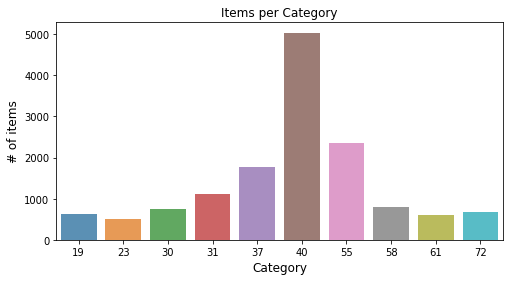

In [32]:
# number of items per cat 
x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

# Single series;

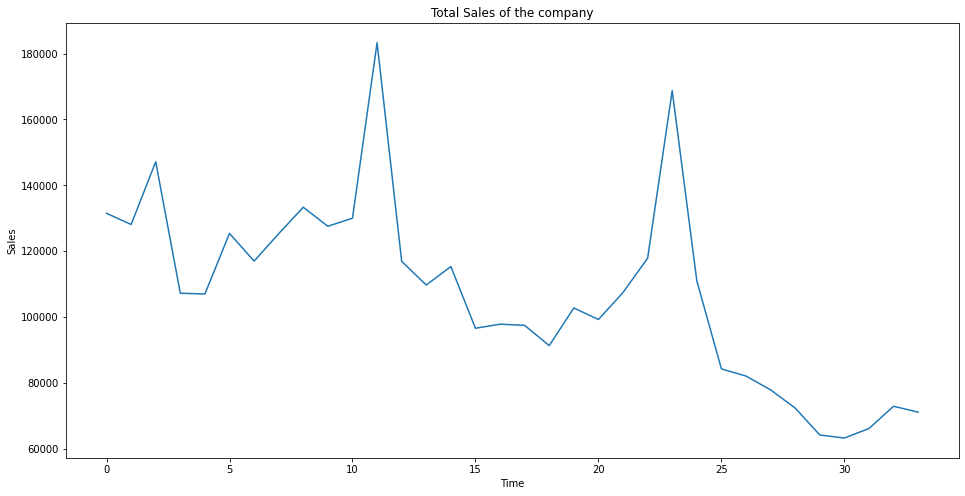

In [33]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

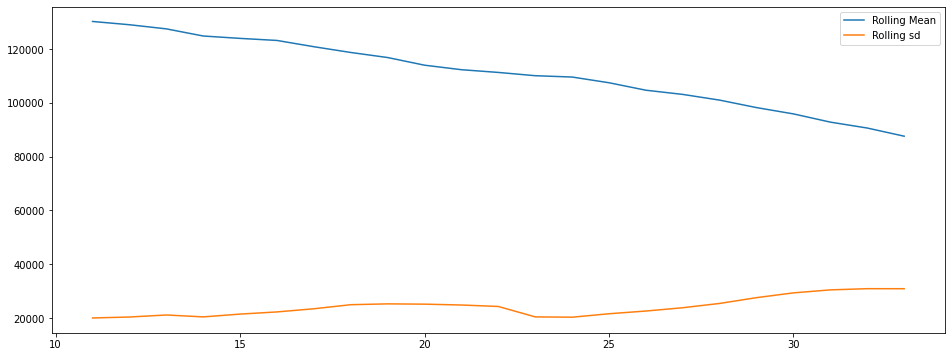

In [34]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

In [35]:
#이거왜안됨?
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

TypeError: seasonal_decompose() got an unexpected keyword argument 'freq'

In [37]:
#이거왜안됨?
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

TypeError: seasonal_decompose() got an unexpected keyword argument 'freq'

## stationary series

![stationary]("https://images.squarespace-cdn.com/content/53ac905ee4b003339a856a1d/1478031434840-PK1G2FWH2YQ9MWK0J2BC/?content-type=image%2Fpng")

### stationary 는 자료의 평균과 분산이 시간 t에 대한 함수가 아닌 것 

### There are multiple tests that can be used to check stationarity.

1. ADF( Augmented Dicky Fuller Test) (우리는 이거 쓴다!)
1. KPSS
1. PP (Phillips-Perron test)

### we assume an additive model, then we can write yt=St+Tt+Et
#### where yt is the data at period t, St is the seasonal component at period t, Tt is the trend-cycle component at period tt and Et is the remainder (or irregular or error) component at period t 

In [38]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [39]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

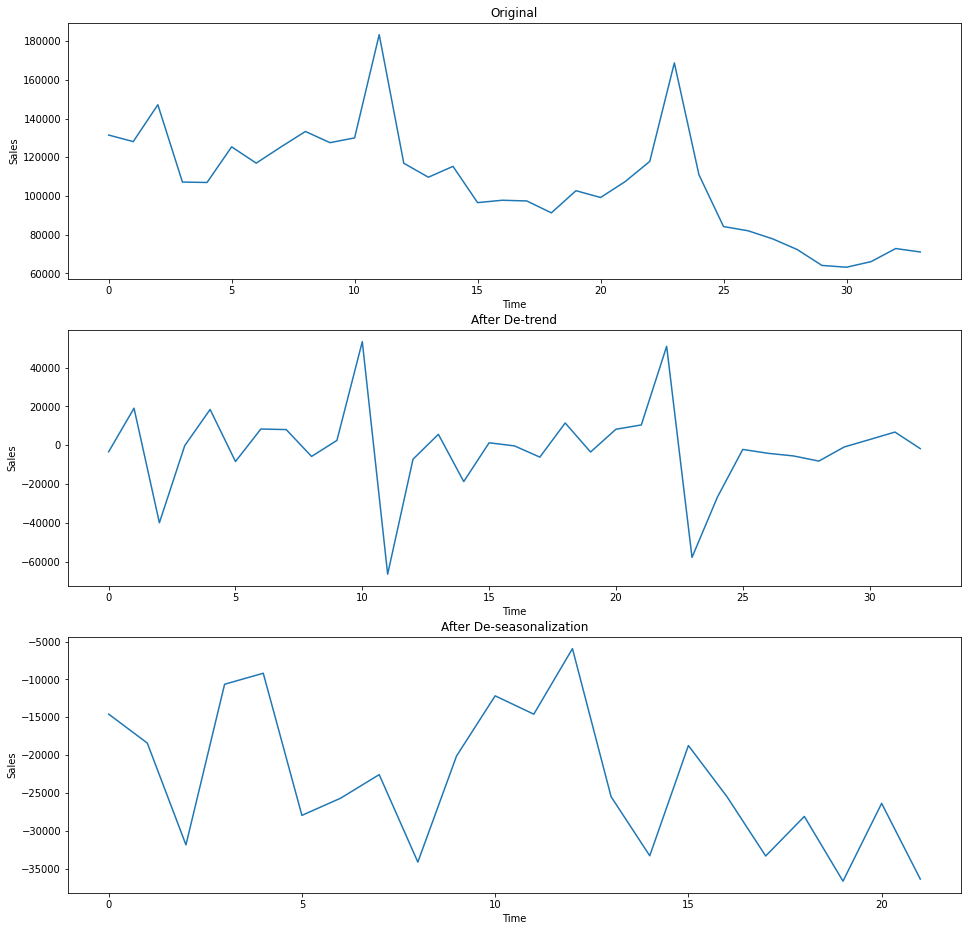

In [40]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [41]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


#### Now after the transformations, our p-value for the DF test is well within 5 %. Hence we can assume Stationarity of the series

## AR, MA and ARMA models:

1.  mA : 
1.  AR  :
1. ARMA : 